## Saliency

The idea behind saliency is pretty simple in hindsight. We compute the gradient of output category with respect to input image.

$$\frac{\partial output}{\partial input}$$


This should tell us how the output value changes with respect to a small change in inputs. We can use these gradients to highlight input regions that cause the most change in the output. Intuitively this should highlight salient image regions that most contribute towards the output.

# NOTE

To visualize activation over final dense layer outputs, we need to switch the `softmax` activation out for `linear` since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide `utils.apply_modifications` to modify network parameters and rebuild the graph.

If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear'.

In [1]:
import keras
from keras.applications import VGG16
from vis.utils import utils
from keras import activations
from vis.visualization import visualize_saliency, overlay
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
# Build the VGG16 network with ImageNet weights
model = VGG16(weights='imagenet', include_top=True)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


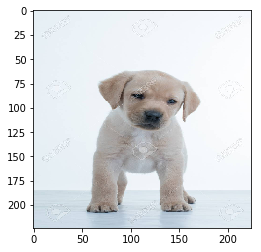

In [4]:
img = np.array(keras.preprocessing.image.load_img(path="./images/labrador.jpeg",target_size=(224,224)))
plt.imshow(img)
plt.show()

Time for saliency visualization.

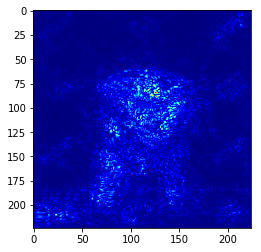

In [5]:
grads = visualize_saliency(model, layer_idx, filter_indices=208, seed_input=img)
    
# visualize grads as heatmap
plt.imshow(grads, cmap='jet')

Not that great. Very noisy. Lets try guided and rectified saliency.

To use guided saliency, we need to set `backprop_modifier='guided'`

vanilla


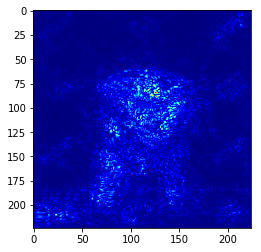

guided


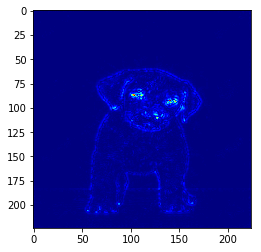

DeConv


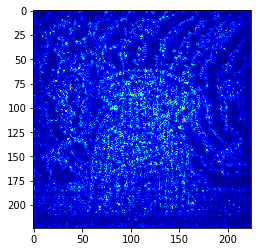

In [6]:
for modifier in [None, 'guided', "relu"]:
    if modifier is None:
        print("vanilla")
    elif modifier == "relu":
        print("DeConv")
    else:
        print(modifier)
    grads = visualize_saliency(model, layer_idx, filter_indices=208, 
                               seed_input=img, backprop_modifier=modifier)
    plt.imshow(grads, cmap='jet')
    plt.show()